# **Keras Retinanet model for Pneumonia Detection**

Below model has been developed referring mainly to below kaggle notebook:
https://www.kaggle.com/chittalpatel/global-wheat-detection-keras-retinanet-eda/notebook

In [ ]:
import pandas as pd
import numpy as np
import os
import cv2
from PIL import Image, ImageDraw
from ast import literal_eval
import matplotlib.pyplot as plt
import urllib
from tqdm.notebook import tqdm

### Installing Keras RetinaNet

In [ ]:
!git clone https://github.com/fizyr/keras-retinanet.git

fatal: destination path 'keras-retinanet' already exists and is not an empty directory.


In [ ]:
%cd keras-retinanet/

!pip install .

/content/keras-retinanet
Processing /content/keras-retinanet
  Created wheel for keras-retinanet: filename=keras_retinanet-1.0.0-cp37-cp37m-linux_x86_64.whl size=168000 sha256=b7818add14abf6f90f4f38dec14928f5b516da9f0cfa94765721b854a8a28676
  Stored in directory: /root/.cache/pip/wheels/b2/9f/57/cb0305f6f5a41fc3c11ad67b8cedfbe9127775b563337827ba
Successfully built keras-retinanet
  Found existing installation: keras-retinanet 1.0.0
    Uninstalling keras-retinanet-1.0.0:
      Successfully uninstalled keras-retinanet-1.0.0


In [ ]:
!python setup.py build_ext --inplace

running build_ext
skipping 'keras_retinanet/utils/compute_overlap.c' Cython extension (up-to-date)
copying build/lib.linux-x86_64-3.7/keras_retinanet/utils/compute_overlap.cpython-37m-x86_64-linux-gnu.so -> keras_retinanet/utils


In [ ]:
import tensorflow as tf
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

### Exploratory Data Analysis

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
root = '/content/drive/My Drive/Capstone/RetinanetPneuDet/'
train_img = root+"JPEGImagesTrainCh1"
#train_img = root+"JPEGImagesNew"
test_img = root+"JPEGImagesTrainCh1"
train_csv = root+"train.csv"
sample_submission = root+"sample_submission.csv"

In [ ]:
train = pd.read_csv(train_csv)
train.head(10)

,patientId,xmin,xmax,ymin,ymax,width,height,Target,bbox
0,00436515-870c-4b36-a041-de91049b9ab4,264.0,477.0,152.0,531.0,213.0,379.0,1,"[264.0, 152.0, 213.0, 379.0]"
1,00436515-870c-4b36-a041-de91049b9ab4,562.0,818.0,152.0,605.0,256.0,453.0,1,"[562.0, 152.0, 256.0, 453.0]"
2,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,483.0,577.0,681.0,160.0,104.0,1,"[323.0, 577.0, 160.0, 104.0]"
3,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,857.0,575.0,712.0,162.0,137.0,1,"[695.0, 575.0, 162.0, 137.0]"
4,00aecb01-a116-45a2-956c-08d2fa55433f,288.0,382.0,322.0,457.0,94.0,135.0,1,"[288.0, 322.0, 94.0, 135.0]"
5,00aecb01-a116-45a2-956c-08d2fa55433f,547.0,666.0,299.0,464.0,119.0,165.0,1,"[547.0, 299.0, 119.0, 165.0]"
6,00c0b293-48e7-4e16-ac76-9269ba535a62,306.0,474.0,544.0,788.0,168.0,244.0,1,"[306.0, 544.0, 168.0, 244.0]"
7,00c0b293-48e7-4e16-ac76-9269ba535a62,650.0,856.0,511.0,795.0,206.0,284.0,1,"[650.0, 511.0, 206.0, 284.0]"
8,00f08de1-517e-4652-a04f-d1dc9ee48593,181.0,387.0,184.0,690.0,206.0,506.0,1,"[181.0, 184.0, 206.0, 506.0]"
9,00f08de1-517e-4652-a04f-d1dc9ee48593,571.0,801.0,275.0,751.0,230.0,476.0,1,"[571.0, 275.0, 230.0, 476.0]"


There are more than one bounding boxes for same image

In [ ]:
print(f"Total Bboxes: {train.shape[0]}")

Total Bboxes: 6700


In [ ]:
unique_images = train['patientId'].unique()
len(unique_images)

4200

In [ ]:
num_total = len(os.listdir(train_img))
num_annotated = len(unique_images)
print(f"There are {num_annotated} annotated images and {num_total - num_annotated} images without annotations.")

There are 4200 annotated images and 16743 images without annotations.


Let us look at how many bounding boxes we have per image

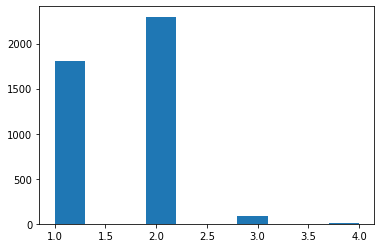

In [ ]:
plt.hist(train['patientId'].value_counts(), bins=10)
plt.show()

A large proportion (more than 50%) of xrays have 2 bounding boxes and the rest have only 1. A very small number of xrays have 3 bounding boxes.

### Resizing the images

In [ ]:
path = '/content/drive/My Drive/Capstone/RetinanetPneuDet/JPEGImagesNew' # Source Folder
dstpath = '/content/drive/My Drive/Capstone/RetinanetPneuDet/JPEGImagesTrainCh1' # Destination Folder

In [ ]:
#images already resized, hence need not run the code again

#import cv2
#import os,glob
#from os import listdir,makedirs

#from os.path import isfile,join
#path = '/content/drive/My Drive/Capstone/RetinanetPneuDet/JPEGImagesNew' # Source Folder
#dstpath = '/content/drive/My Drive/Capstone/RetinanetPneuDet/JPEGImagesTrainCh1' # Destination Folder
#try:
#    makedirs(dstpath)
#except:
#    print ("Directory already exist, images will be written in same folder")
# Folder won't used
#files = list(filter(lambda f: isfile(join(path,f)), listdir(path)))
#for image in files:
#    try:
#       img = cv2.imread(os.path.join(path,image))
#        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#        dstPath = join(dstpath,image)
#        cv2.imwrite(dstPath,gray)
#    except:
#        print ("{} is not converted".format(image))
#for fil in glob.glob("*.jpg"):
#    try:
#        image = cv2.imread(fil) 
#        gray_image = cv2.cvtColor(os.path.join(path,image), cv2.COLOR_BGR2GRAY) # convert to greyscale
#        cv2.imwrite(os.path.join(dstpath,fil),gray_image)
#    except:
#        print('{} is not converted')

In [ ]:
y = np.expand_dims(dstpath+"3036fb15-305b-4e9b-93ab-4e555a0fd323.jpg", axis=-1)
y.shape

(1,)

In [ ]:
#check number of files created. need not run again.
#import os

#path, dirs, files = next(os.walk("/content/drive/My Drive/Capstone/RetinanetPneuDet/JPEGImagesTrainCh1"))
#file_count = len(files)
#print (file_count)

In [ ]:
y = np.expand_dims(dstpath+"0cac94e3-15f2-4657-beae-b508b5e0d176.jpg", axis=-1)
y.shape

(1,)

### Visualizing the images

In [ ]:
def get_bbox_area(bbox):
    bbox = literal_eval(bbox)
    return bbox[2] * bbox[3]

In [ ]:
#new path for train images
train_img = root+"JPEGImagesTrainCh1"

In [ ]:
def show_images(images, num = 5):
    
    images_to_show = np.random.choice(images, num)

    for image_id in images_to_show:

        image_path = os.path.join(train_img, image_id + ".jpg")
        image = Image.open(image_path)

        # get all bboxes for given image in [xmin, ymin, width, height]
        bboxes = [literal_eval(box) for box in train[train['patientId'] == image_id]['bbox']]

        # visualize them
        draw = ImageDraw.Draw(image)
        for bbox in bboxes:    
            draw.rectangle([bbox[0], bbox[1], bbox[2], bbox[3]], width=3)

        plt.figure(figsize = (10,10))
        plt.imshow(image)
        plt.show()

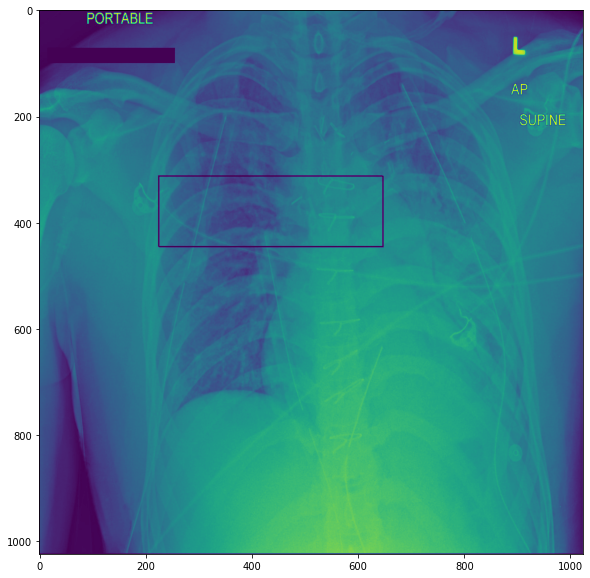

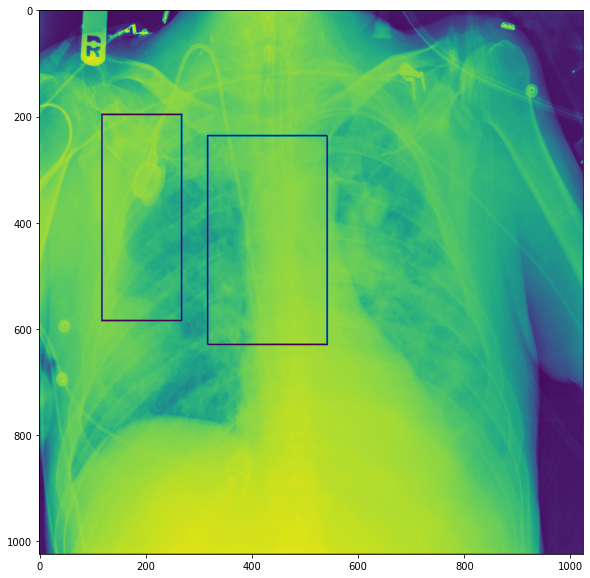

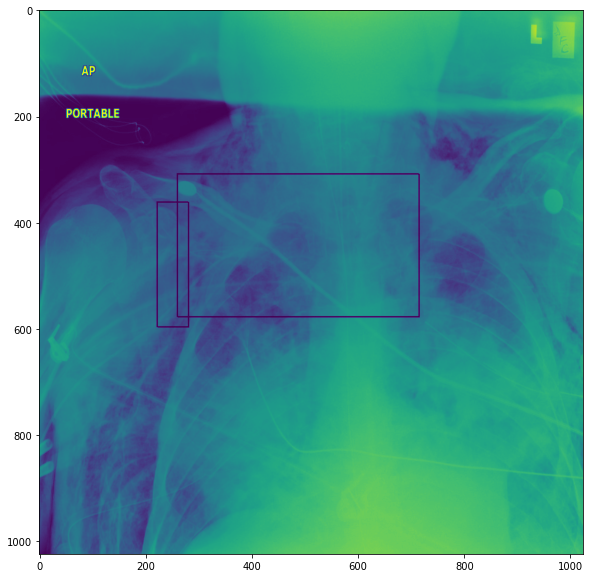

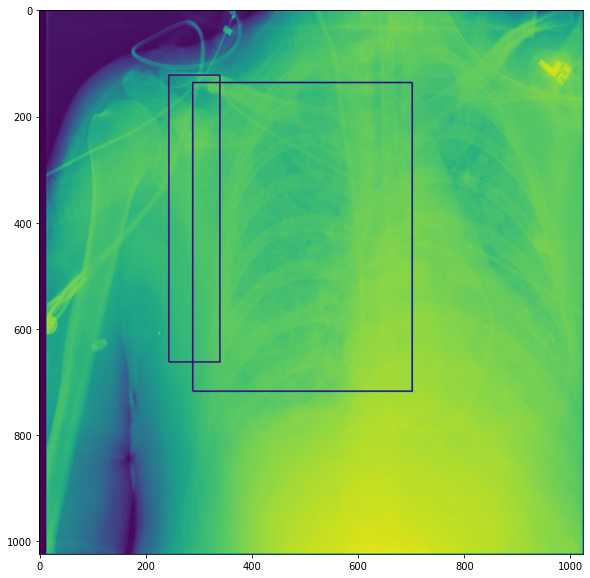

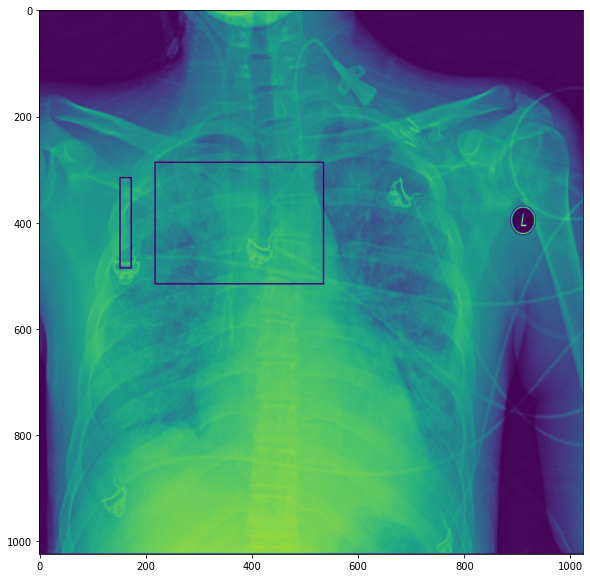

In [ ]:
show_images(unique_images)

### Pre-processing of data for Keras-RetinaNet

In [ ]:
bboxs=[ bbox[1:-1].split(', ') for bbox in train['bbox']]
bboxs=[ f"{int(float(bbox[0]))},{int(float(bbox[1]))},{int(float(bbox[0]))+int(float(bbox[2]))},{int(float(bbox[1])) + int(float(bbox[3]))},LungOpacity" for bbox in bboxs]
train['bbox_']=bboxs
train.head()

,patientId,xmin,xmax,ymin,ymax,width,height,Target,bbox,bbox_
0,00436515-870c-4b36-a041-de91049b9ab4,264.0,477.0,152.0,531.0,213.0,379.0,1,"[264.0, 152.0, 213.0, 379.0]","264,152,477,531,LungOpacity"
1,00436515-870c-4b36-a041-de91049b9ab4,562.0,818.0,152.0,605.0,256.0,453.0,1,"[562.0, 152.0, 256.0, 453.0]","562,152,818,605,LungOpacity"
2,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,483.0,577.0,681.0,160.0,104.0,1,"[323.0, 577.0, 160.0, 104.0]","323,577,483,681,LungOpacity"
3,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,857.0,575.0,712.0,162.0,137.0,1,"[695.0, 575.0, 162.0, 137.0]","695,575,857,712,LungOpacity"
4,00aecb01-a116-45a2-956c-08d2fa55433f,288.0,382.0,322.0,457.0,94.0,135.0,1,"[288.0, 322.0, 94.0, 135.0]","288,322,382,457,LungOpacity"


In [ ]:
train_df=train[['patientId','bbox_']]
train_df.head()

,patientId,bbox_
0,00436515-870c-4b36-a041-de91049b9ab4,"264,152,477,531,LungOpacity"
1,00436515-870c-4b36-a041-de91049b9ab4,"562,152,818,605,LungOpacity"
2,00704310-78a8-4b38-8475-49f4573b2dbb,"323,577,483,681,LungOpacity"
3,00704310-78a8-4b38-8475-49f4573b2dbb,"695,575,857,712,LungOpacity"
4,00aecb01-a116-45a2-956c-08d2fa55433f,"288,322,382,457,LungOpacity"


In [ ]:
train_df=train_df.sample(frac=1).reset_index(drop=True)
train_df.head()

,patientId,bbox_
0,95e6c3a5-1f34-4b87-8a71-a73032470fc0,"189,243,503,902,LungOpacity"
1,94808997-3c67-4d45-bf6e-423f3705d30d,"285,563,427,700,LungOpacity"
2,9eb988cd-aecc-4335-ad09-b580be434377,"437,419,706,727,LungOpacity"
3,5bfdc9ee-e21d-46e5-bbfc-20cea10c3175,"489,203,845,740,LungOpacity"
4,39ce47c6-a221-4399-8ac3-21b0b4a323f6,"492,417,731,694,LungOpacity"


In [ ]:
train_df_new = train_df.iloc[0:5000,:]
train_df_new

,patientId,bbox_
0,95e6c3a5-1f34-4b87-8a71-a73032470fc0,"189,243,503,902,LungOpacity"
1,94808997-3c67-4d45-bf6e-423f3705d30d,"285,563,427,700,LungOpacity"
2,9eb988cd-aecc-4335-ad09-b580be434377,"437,419,706,727,LungOpacity"
3,5bfdc9ee-e21d-46e5-bbfc-20cea10c3175,"489,203,845,740,LungOpacity"
4,39ce47c6-a221-4399-8ac3-21b0b4a323f6,"492,417,731,694,LungOpacity"
...,...,...
4995,0c391e0f-9927-48ce-801f-02eb000f72c3,"114,249,441,938,LungOpacity"
4996,a7a45cd9-785e-402c-a66c-4762b71ec4bb,"123,383,406,873,LungOpacity"
4997,36f51cc5-a28d-48f0-a086-df424f7f2c94,"209,594,408,798,LungOpacity"
4998,4217397c-f5d1-4890-8d71-5c6eebf8340e,"549,356,822,573,LungOpacity"


In [ ]:
test_df = train_df.iloc[5001:6700,:]
test_df

,patientId,bbox_
5001,17c15be0-a3be-49a4-a923-955ff5c962b2,"138,451,456,781,LungOpacity"
5002,01dc817c-3cfa-49fe-8662-518edc30652a,"368,677,469,816,LungOpacity"
5003,45415872-fc2a-43ba-869d-5131c57622f1,"613,309,877,763,LungOpacity"
5004,47ba820c-c63e-4efa-90af-7b88e6741151,"169,181,389,646,LungOpacity"
5005,7f957ae7-0d22-47c2-8c41-ecf5aeccb1f0,"620,597,829,816,LungOpacity"
...,...,...
6695,463c04a5-94b8-4969-a725-a58c2b6211c1,"258,283,473,787,LungOpacity"
6696,4206173d-0db2-4f32-80fb-0bd99d5532e1,"570,402,825,601,LungOpacity"
6697,448c6151-2bb5-4df3-b07e-7f86f3a5737a,"246,386,474,786,LungOpacity"
6698,41bf2042-53a2-44a8-9a29-55e643af5ac0,"217,474,343,634,LungOpacity"


### Preparing files for training

Annotation file should contain all the path of all images and their corresponding bounding boxes

In [ ]:
with open("annotations.csv","w") as file:
    for idx in range(len(train_df_new)):
        file.write(train_img+"/"+train_df_new.iloc[idx,0]+".jpg"+","+train_df_new.iloc[idx,1]+"\n")

Class file should contain the number of classes. In our case, it is just 1 class - LungOpacity

In [ ]:
with open("classes.csv","w") as file:
    file.write("LungOpacity,0")

## Downloading pre trained model

In [ ]:
PRETRAINED_MODEL = './snapshots/_pretrained_model.h5'

URL_MODEL = 'https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet50_coco_best_v2.1.0.h5'
urllib.request.urlretrieve(URL_MODEL, PRETRAINED_MODEL)

print('Downloaded pretrained model to ' + PRETRAINED_MODEL)

Downloaded pretrained model to ./snapshots/_pretrained_model.h5


#### Model Parameters

#### Training the model

In [ ]:
!keras_retinanet/bin/train.py \
  --random-transform \
  --workers 0 \
  --weights {PRETRAINED_MODEL} \
  --batch-size 25 \
  --steps 100 \
  --image-min-side 512\
  --image-max-side 512\
  --epochs 10 \
  csv annotations.csv classes.csv

  #changed nms_threshold in filter_detections.py from 0.5 to 0.2
  #changed freeze_backbone from false to true in train.py

2021-03-03 05:51:00.812417: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Creating model, this may take a second...
2021-03-03 05:51:05.510600: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-03-03 05:51:05.511461: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-03-03 05:51:05.534206: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-03-03 05:51:05.534765: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-03-03 05:51:05.534802:

In [ ]:
#!keras_retinanet/bin/train.py --random-transform --weights {PRETRAINED_MODEL} --batch-size {BATCH_SIZE} --steps {STEPS} --epochs {EPOCHS} --no-resize csv annotations.csv classes.csv

### Loading the trained model

In [ ]:
!ls snapshots

_pretrained_model.h5  resnet50_csv_04.h5  resnet50_csv_08.h5
resnet50_csv_01.h5    resnet50_csv_05.h5  resnet50_csv_09.h5
resnet50_csv_02.h5    resnet50_csv_06.h5  resnet50_csv_10.h5
resnet50_csv_03.h5    resnet50_csv_07.h5


In [ ]:
#model_path = os.path.join('snapshots', sorted(os.listdir('snapshots'), reverse=True)[0])

model = models.load_model('snapshots/resnet50_csv_10.h5', backbone_name='resnet50')
model = models.convert_model(model)

#Converting to inference model using the installed script:
#!keras_retinanet/bin/convert_model.py 'snapshots/resnet50_csv_03.h5' root+"snapshots/Inference/"

# load label to names mapping for visualization purposes
labels_to_names = pd.read_csv('classes.csv',header=None).T.loc[0].to_dict()

In [ ]:
def img_inference(img_path):
  image = read_image_bgr(img_infer)

  # copy to draw on
  draw = image.copy()
  draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

  # preprocess image for network
  image = preprocess_image(image)
  image, scale = resize_image(image)

  # process image
  start = time.time()
  boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
  print("processing time: ", time.time() - start)

  # correct for image scale
  boxes /= scale

  # visualize detections
  for box, score, label in zip(boxes[0], scores[0], labels[0]):
      # scores are sorted so we can break
      if score < THRES_SCORE:
          break

      color = label_color(label)

      b = box.astype(int)
      draw_box(draw, b, color=color)

      caption = "{} {:.3f}".format(labels_to_names[label], score)
      draw_caption(draw, b, caption)

  plt.figure(figsize=(10, 10))
  plt.axis('off')
  plt.imshow(draw)
  plt.show()

Saving 2408fba1-6704-44c7-b598-4e62504df533.jpg to 2408fba1-6704-44c7-b598-4e62504df533.jpg
Running inference on: 2408fba1-6704-44c7-b598-4e62504df533.jpg
processing time:  3.595120906829834


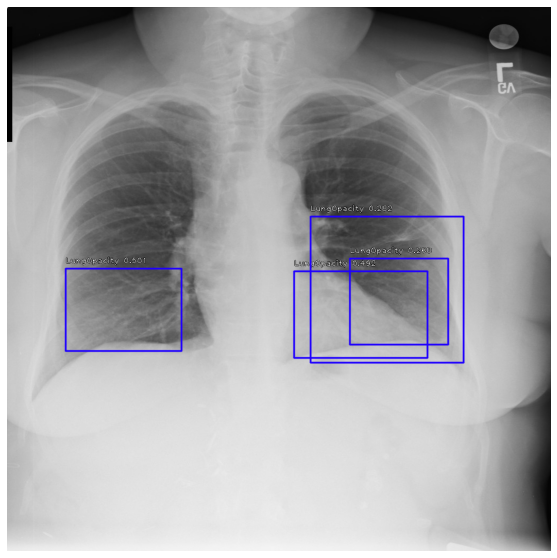

In [ ]:
THRES_SCORE = .25
from google.colab import files
import time
uploaded = files.upload()
img_infer = list(uploaded)[0]

print('Running inference on: ' + img_infer)
img_inference(img_infer)

### Predictions

In [ ]:
li=os.listdir(test_img)
l5=li[:5]
l5

['bf7b0977-4f77-45a7-8c03-77602f82b905.jpg',
 'bf7bc9a6-d454-4edd-8752-9273448a3b10.jpg',
 'bf7beb9f-65f8-4b05-a9b3-85b7f8b5b726.jpg',
 'bf842c92-c6ed-4be4-b188-c05ec8bf8dc2.jpg',
 'bf8609b1-a24f-4129-855e-fe3a0862da91.jpg']

In [ ]:
def predict(image):
    image = preprocess_image(image.copy())
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
    return boxes, scores, labels

In [ ]:
THRES_SCORE = 0.25

def draw_detections(image, boxes, scores, labels):
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        if score < THRES_SCORE:
            break

        color = label_color(label)

        b = box.astype(int)
        draw_box(image, b, color=color)

        caption = "{:.3f}".format(score)
        draw_caption(image, b, caption)

In [ ]:
def show_detected_objects(image_name):
    img_path = test_img+'/'+image_name
  
    image = read_image_bgr(img_path)

    boxes, scores, labels = predict(image)
    print(boxes[0,0].shape)
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    draw_detections(draw, boxes, scores, labels)
    plt.figure(figsize=(15,10))
    plt.axis('off')
    plt.imshow(draw)
    plt.show()

(4,)


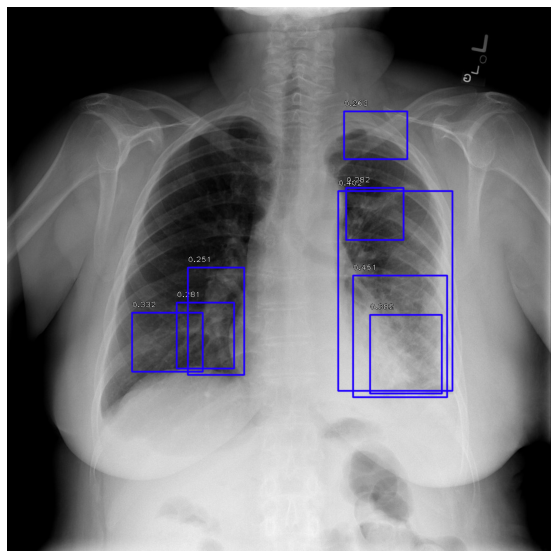

(4,)


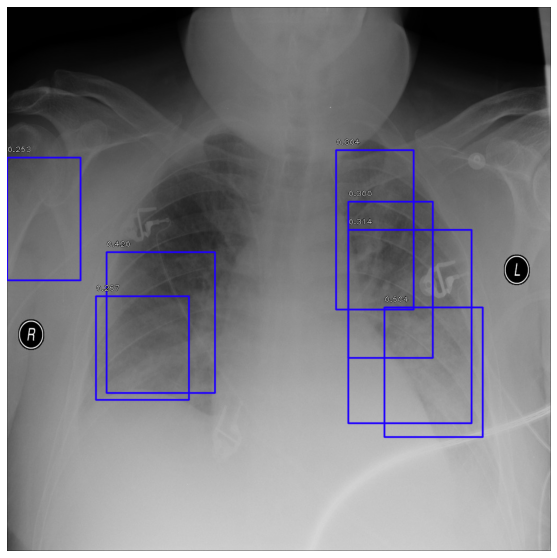

(4,)


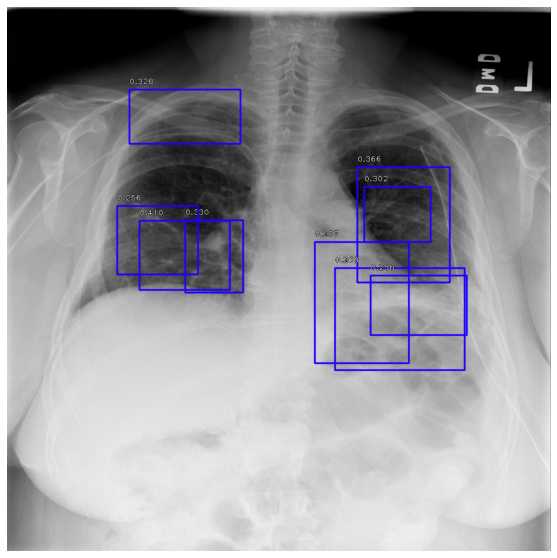

(4,)


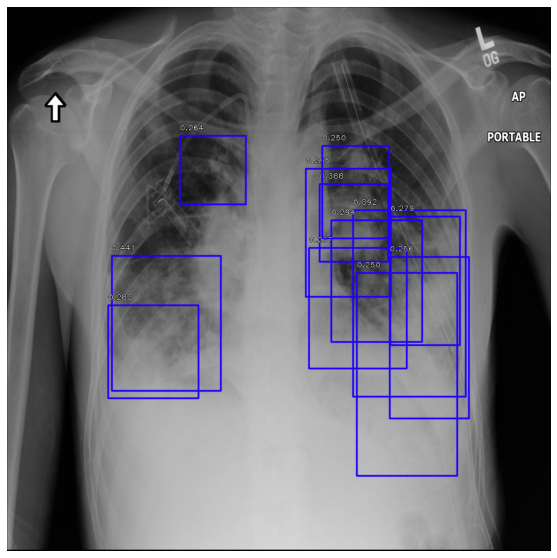

(4,)


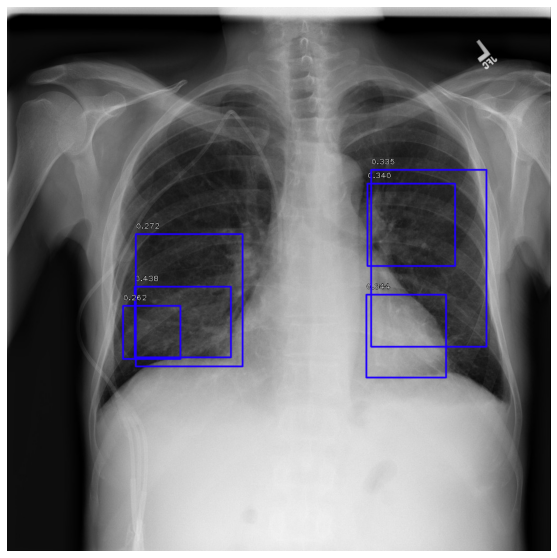

In [ ]:
for img in l5:
    show_detected_objects(img)

In [ ]:
#!keras_retinanet/bin/evaluate.py csv annotations_test.csv classes.csv ./snapshots/resnet50_csv_03.h5

### Model validation

In [ ]:
with open("annotations_test.csv","w") as file:
    for idx in range(len(test_df)):
        file.write(test_img+"/"+test_df.iloc[idx,0]+".jpg"+","+test_df.iloc[idx,1]+"\n")

In [ ]:
df_valid= pd.read_csv('annotations_test.csv', header=None)
df_valid.head()

,0,1,2,3,4,5
0,/content/drive/My Drive/Capstone/RetinanetPneu...,138,451,456,781,LungOpacity
1,/content/drive/My Drive/Capstone/RetinanetPneu...,368,677,469,816,LungOpacity
2,/content/drive/My Drive/Capstone/RetinanetPneu...,613,309,877,763,LungOpacity
3,/content/drive/My Drive/Capstone/RetinanetPneu...,169,181,389,646,LungOpacity
4,/content/drive/My Drive/Capstone/RetinanetPneu...,620,597,829,816,LungOpacity


In [ ]:
n_classes= pd.read_csv('classes.csv', header=None)

classes= {}
classes_r= {}
for name, roll in zip(n_classes[0], n_classes[1]):
    classes[name]= roll
    classes_r[roll]=name

In [ ]:
uniq= df_valid[0].unique().shape[0]
classes

{'LungOpacity': 0}

In [ ]:
def predict(path, th=0.25, draw=True, show_time=True):
    
    # load image
    image = read_image_bgr(path)
    # copy to draw on
    image2 = image.copy()
    #image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)
    
    # process image
    start = time.time()
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
    if show_time:
        print("processing time: ", time.time() - start)
    # correct for image scale
    boxes /= scale
    
    if draw:
        for box, score, label in zip(boxes[0], scores[0], labels[0]):
        # scores are sorted 
            if score < th:
                break
            color = label_color(label)
            b = box.astype(int)
            draw_box(image2, box, color=color)
            draw_caption(image2, box, classes_r[label])
        return image2
    else:
        return boxes[0], scores[0], labels[0]

In [ ]:
def grd_vs_pred(i, th= 0.25):
    path= df_valid[0].unique()[i]
    grd_img= read_image_bgr(path)

    for r, row in df_valid[df_valid[0]==df_valid[0][i]].iterrows():
        color= label_color(classes[row[5]])
        grd_img= cv2.rectangle(np.array(grd_img), (row[1], row[2]), (row[3], row[4]), color, 2)
        draw_caption(grd_img, row[1:5].values, row[5])
    pred_img= predict(path, th=th)
    
    return grd_img, pred_img

In [ ]:
import time

processing time:  0.0565643310546875
processing time:  0.05699634552001953
processing time:  0.05651688575744629
processing time:  0.056640625


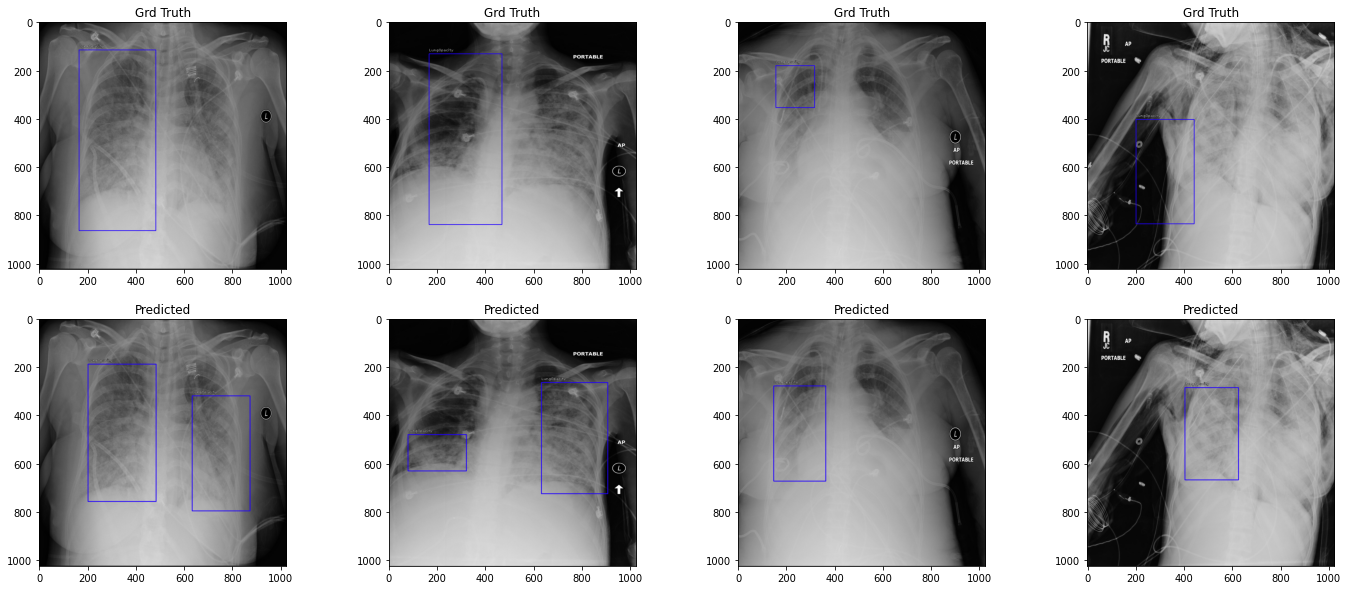

In [ ]:
f, ax= plt.subplots(2, 4, figsize=(24, 10))

for i in range(4):
    np.random.seed(i*90)
    grd, pred= grd_vs_pred(np.random.randint(uniq), th= 0.5)
    ax[0][i%4].imshow(grd); ax[1][i%4].imshow(pred)
    ax[0][i%4].set_title('Grd Truth')
    ax[1][i%4].set_title('Predicted')
plt.show()

In [ ]:
import argparse
from datetime import date
import os
import sys
import tensorflow as tf

In [ ]:
from keras_retinanet import models
from keras_retinanet.preprocessing.csv_generator import CSVGenerator
from keras_retinanet.preprocessing.pascal_voc import PascalVocGenerator
from keras_retinanet.utils.anchors import make_shapes_callback
from keras_retinanet.utils.config import read_config_file, parse_anchor_parameters, parse_pyramid_levels
from keras_retinanet.utils.eval import evaluate
from keras_retinanet.utils.gpu import setup_gpu
from keras_retinanet.utils.tf_version import check_tf_version

In [ ]:
!keras_retinanet/bin/evaluate.py --convert-model csv annotations_test.csv classes.csv ./snapshots/resnet50_csv_10.h5

2021-03-03 06:57:46.139632: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Loading model, this may take a second...
2021-03-03 07:01:28.118104: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-03-03 07:01:28.118971: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-03-03 07:01:28.123396: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-03-03 07:01:28.123863: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-03-03 07:01:28.123914: 